### 🔰PyTorchでニューラルネットワーク基礎 #18 【分位点回帰・時系列分析】

### 内容
* Qiitaの記事と連動しています
* 因果畳み込みと分位点回帰を利用した日経225の予測
* 時系列データである株価データを利用して悲観的・楽観的予測の構造を学習する

### データについて
* データ：data/nikkei_225.csv
* 2021年から2025年6月中旬くらいのデータ
* 日経225データはyfinanceを利用して取得


In [1]:
import pandas as pd
import numpy as np

In [2]:
# CSVファイルの読み込み
data = pd.read_csv("./data/nikkei_225.csv")
data.head(5)

,Date,Open,High,Low,Close,Volume
0,2021-01-04,27575.57,27602.11,27042.32,27258.38,51500000
1,2021-01-05,27151.38,27279.78,27073.46,27158.63,55000000
2,2021-01-06,27102.85,27196.40,27002.18,27055.94,72700000
3,2021-01-07,27340.46,27624.73,27340.46,27490.13,98900000
4,2021-01-08,27720.14,28139.03,27667.75,28139.03,84900000


In [3]:
# 日経225の値を10,000円で割り算して値を小さくする
#
scaling_factor = 10_000
x_open = data["Open"]/scaling_factor
x_high = data["High"]/scaling_factor
x_low = data["Low"]/scaling_factor
x_close = data["Close"]/scaling_factor

In [4]:
win_size = 5
XO = [x_open[start:start+win_size] for start in range(len(data)-win_size)]
XH = [x_high[start:start+win_size] for start in range(len(data)-win_size)]
XL = [x_low[start:start+win_size] for start in range(len(data)-win_size)]
XC = [x_close[start:start+win_size] for start in range(len(data)-win_size)]
t = x_open[win_size:]

xo = np.array(XO)
xh = np.array(XH)
xl = np.array(XL)
xc = np.array(XC)

xo = xo.reshape(xo.shape[0], 1, xo.shape[1])
xh = xh.reshape(xh.shape[0], 1, xh.shape[1])
xl = xl.reshape(xl.shape[0], 1, xl.shape[1])
xc = xc.reshape(xc.shape[0], 1, xc.shape[1])
X = np.concatenate([xo, xh, xl, xc], axis=1)
T = np.array(t)

X.shape, T.shape, #x.shape

((1087, 4, 5), (1087,))

## 3. 因果畳み込みを利用したネットワークの作成と学習

In [5]:
import torch
import torch.nn as nn

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

x = torch.FloatTensor(X).to(device)
t = torch.FloatTensor(T).view(-1,1).to(device)

period = 100
x_train = x[:-period]
x_test = x[-period:]
t_train = t[:-period]
t_test = t[-period:]

x_train.shape, x_test.shape, t_train.shape, t_test.shape

device: cuda


(torch.Size([987, 4, 5]),
 torch.Size([100, 4, 5]),
 torch.Size([987, 1]),
 torch.Size([100, 1]))

### ネットワークの構造

In [7]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # kernel_size=5の場合、padding=4にすることでcausal convolutionを実現
        # 出力長を入力長と同じにするため
        self.kernel_size = 5
        self.padding = self.kernel_size - 1
        
        self.conv1 = nn.Conv1d(in_channels=4,  out_channels=10, kernel_size=self.kernel_size, padding=self.padding)
        self.conv2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=self.kernel_size, padding=self.padding)
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=self.kernel_size, padding=self.padding)
        self.flat  = nn.Flatten()
        self.fc    = nn.Linear(in_features=10*5, out_features=3)
        self.relu  = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, input_size, sequence_length)
        
        # 1層目: causal convolution
        h = self.conv1(x)
        h = h[:, :, :-self.padding] # 未来の情報を除去（右端をカット）
        h = self.relu(h)
        
        # 2層目: causal convolution  
        h = self.conv2(h)
        h = h[:, :, :-self.padding]
        h = self.relu(h)
        
        # 3層目: causal convolution
        h = self.conv3(h)
        h = h[:, :, :-self.padding]
        # 出力層
        h = self.flat(h)
        y = self.fc(h)
        
        return y


In [8]:
model = DNN()
model.to(device)

DNN(
  (conv1): Conv1d(4, 10, kernel_size=(5,), stride=(1,), padding=(4,))
  (conv2): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(4,))
  (conv3): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(4,))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
)

In [9]:
# 入力サイズを指定 (channels, length)
from torchinfo import summary
summary(model, (1,4, 5))

Layer (type:depth-idx)                   Output Shape              Param #
DNN                                      [1, 3]                    --
├─Conv1d: 1-1                            [1, 10, 9]                210
├─ReLU: 1-2                              [1, 10, 5]                --
├─Conv1d: 1-3                            [1, 10, 9]                510
├─ReLU: 1-4                              [1, 10, 5]                --
├─Conv1d: 1-5                            [1, 10, 9]                510
├─Flatten: 1-6                           [1, 50]                   --
├─Linear: 1-7                            [1, 3]                    153
Total params: 1,383
Trainable params: 1,383
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [10]:
# 損失関数のクラスと定義
class PinballLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = torch.FloatTensor(quantiles).to(device)
        
    def forward(self, pred_values, actual_values):
        error = actual_values - pred_values
        # ピンボール損失の計算: max((q-1)*residual, q*residual)
        M = torch.max((self.quantiles - 1) * error, self.quantiles * error)
        loss = M.mean(dim=0).sum()     # 各サンプルの全分位点での損失平均を取り、合計する
        return loss

# 分位点の設定
quantiles = [0.1, 0.5, 0.9]


In [11]:
# ハイパーパラメータ
LOOP = 12_000

In [12]:
criterion = PinballLoss(quantiles=quantiles)
optimizer = torch.optim.AdamW(model.parameters())

In [13]:
# 学習ループ
model.train()
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x_train)
    loss = criterion(y,t_train)
    if (epoch+1)%1000 == 0:
        print(epoch,"\tloss:", loss.item())
    loss.backward()
    optimizer.step()

999 	loss: 0.04779580980539322
1999 	loss: 0.03591214865446091
2999 	loss: 0.034002915024757385
3999 	loss: 0.0335167832672596
4999 	loss: 0.027738897129893303
5999 	loss: 0.02508729323744774
6999 	loss: 0.03619980812072754
7999 	loss: 0.03602193295955658
8999 	loss: 0.02245081216096878
9999 	loss: 0.02259945124387741
10999 	loss: 0.03215698152780533
11999 	loss: 0.022069059312343597


In [15]:
# save the model
torch.save(model.state_dict(), "./model/quantile_conv1d.model")

In [16]:
# 保存モデルの読み込み
param = torch.load("./model/quantile_conv1d.model", weights_only=False)
model.load_state_dict(param)

<All keys matched successfully>

### グラフ
* matplotlibで描画
* cudaからcpuに戻してプロットするのを忘れずに

In [17]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [18]:
model.eval()
y_test = model(x_test)

prediction = y_test.detach().cpu().numpy()
real = t_test.detach().cpu().numpy()
y_train = t_train.detach().cpu().numpy()

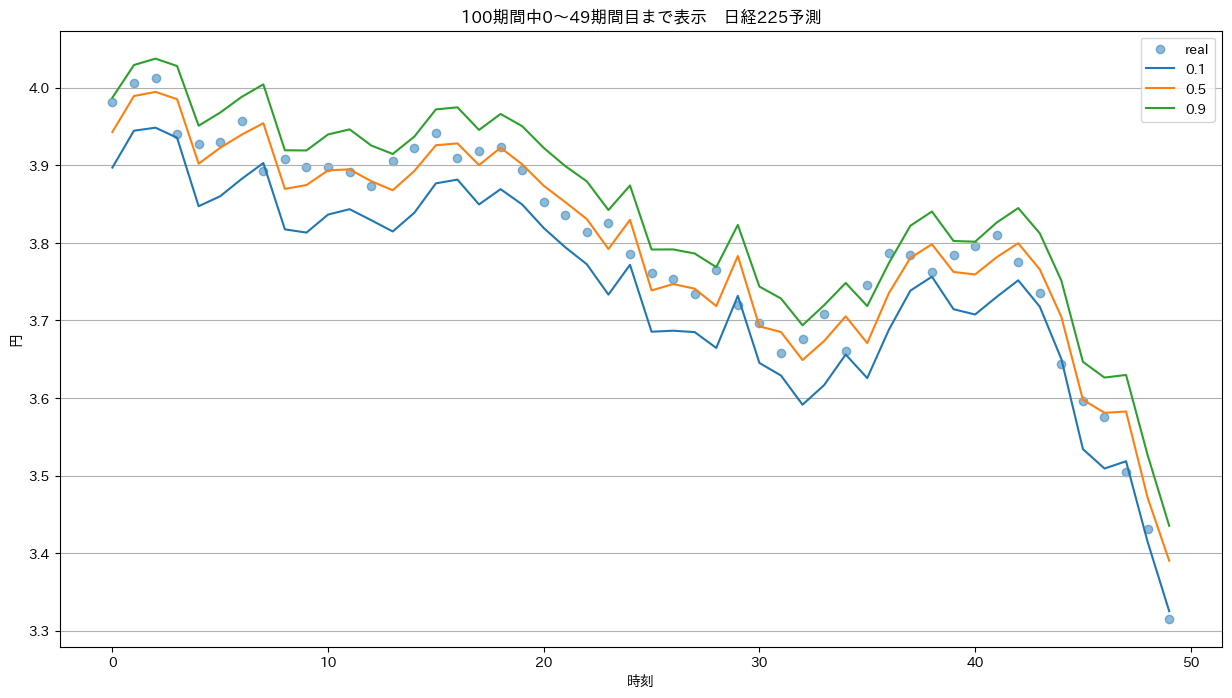

In [26]:
e = 50
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(range(50), real[:e], label="real",alpha=0.5)
for i, t in enumerate(quantiles):
    # 予測曲線をプロット
    ax.plot(prediction.T[i][:e], label=t)
# グラフのタイトルとラベルを設定
ax.set_title(f"100期間中0〜{e-1}期間目まで表示　日経225予測")
ax.grid(axis="y")
ax.set_xlabel("時刻")
ax.set_ylabel("円")
ax.legend()
plt.show()

### 指標の計算
* 記事の数値と多少異なります．大まかな傾向は等しいかと
* 計算している指標についてですが，[🔰PyTorchでニューラルネットワーク基礎 #9.5 【時系列分析・指標】](https://qiita.com/AzukiImo/items/e02f9ec2422cddf01e46)にて紹介してあります．

**scikit-learnですぐ求められる指標**

In [18]:
# 予測結果の評価
from sklearn.metrics import (
    mean_absolute_error,             # 平均絶対誤差
    root_mean_squared_error,         # 二乗平均平方誤差
    mean_absolute_percentage_error,  # 平均絶対パーセント誤差
    mean_squared_error,              # 平均二乗誤差
    r2_score                         # 決定係数
)

mae = mean_absolute_error(real, prediction)
rmse = root_mean_squared_error(real, prediction)
mape = mean_absolute_percentage_error(real, prediction)

# ついでにMSEとR2
mse = mean_squared_error(real, prediction)
r2 = r2_score(real, prediction)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape*100:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 0.0241
RMSE: 0.0299
MAPE: 0.6541%
MSE: 0.0009
R²: 0.9717


**予測値と実測値の方向性がどれくらい等しいか？**
* 上昇下落をあてることが正義となる指標です

In [19]:
# Direction Accuracy
def direction_accuracy(y_true, y_pred):
    """
    予測値と実測値の方向性一致率を計算
    """
    # 前日からの変化方向を計算
    true_direction = np.sign(np.diff(y_true.flatten()))
    pred_direction = np.sign(np.diff(y_pred.flatten()))
    
    # 方向が一致した割合
    accuracy = np.mean(true_direction == pred_direction)
    return accuracy


# 計算
dir_acc = direction_accuracy(real, prediction)

print(f"Direction Accuracy: {dir_acc:.3f} ({dir_acc*100:.1f}%)")


Direction Accuracy: 0.657 (65.7%)


* ニューラルネットワークを利用した時系列予測は，直前の期をそのまま予測値に利用するナイーブ予測になりがち．
* ナイーブ予測と作成したモデルを比較する指標がMASE（平均絶対スケール誤差）

In [20]:
def mase(y_true, y_pred, y_train):
    # モデル予測のMAE
    mae_pred = np.mean(np.abs(y_true - y_pred))
    
    # ナイーブ予測のMAE（前期の値を使用）
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    
    return mae_pred / mae_naive


mase_model = mase(real, prediction, y_train)
print(f"MASE MODEL: {mase_model:.3f}")

mase_naive = mase(real[1:],real[:-1], y_train)
print(f"MASE NAIVE: {mase_naive:.3f}")


MASE MODEL: 0.898
MASE NAIVE: 1.153


### ダイボールド・マリアーノ検定：2つのモデルの予測精度を統計的に検定する方法
* dieboldmarianoライブラリを利用

In [21]:
from dieboldmariano import dm_test


actual = real[1:].reshape(-1)
f_model = prediction[1:].reshape(-1)
s_model = real[:-1].reshape(-1)

print(actual.shape, f_model.shape, s_model.shape)

# テストを実行
dm, p_value = dm_test(actual, f_model, s_model)
print(f"DM統計量: {dm:.5f}")
print(f"p値: {p_value:.5f}")
print(f"有意水準5%で差があるか: {'Yes' if p_value < 0.05 else 'No'}")

print("\n")
if p_value < 0.05:
    if dm < 0:
        print(f"DM: {dm:.2f}\nDM<0なのでモデル１の方がナイーブモデルよりも精度が高い")
    else:
        print(f"DM: {dm:.2f}\nDM>0なのでナイーブモデルの方がモデル１よりも精度が高い")
else:
    print("モデル１はナイーブ予測と同等")


(99,) (99,) (99,)
DM統計量: -2.63465
p値: 0.00979
有意水準5%で差があるか: Yes


DM: -2.63
DM<0なのでモデル１の方がナイーブモデルよりも精度が高い
